In [54]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt

Напишем нейросеть u-net используя стандартные слои keras.

In [55]:
class UNet():
    def __init__(self):
        print ('build UNet ...')

    def get_crop_shape(self, target, refer): #функция для определения параметра cropping в Cropping2D слоях.
        cw = (target.get_shape()[2] - refer.get_shape()[2])
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        ch = (target.get_shape()[1] - refer.get_shape()[1])
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)

    def create_model(self, img_shape, num_class):

        concat_axis = 3
        inputs = layers.Input(shape = img_shape)

        conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
        conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
        conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
        pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
        conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
        pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
        conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

        up_conv5 = layers.UpSampling2D(size=(2, 2))(conv5)
        ch, cw = self.get_crop_shape(conv4, up_conv5)
        crop_conv4 = layers.Cropping2D(cropping=(ch,cw))(conv4)
        up6 = layers.concatenate([up_conv5, crop_conv4], axis=concat_axis)
        conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
        conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

        up_conv6 = layers.UpSampling2D(size=(2, 2))(conv6)
        ch, cw = self.get_crop_shape(conv3, up_conv6)
        crop_conv3 = layers.Cropping2D(cropping=(ch,cw))(conv3)
        up7 = layers.concatenate([up_conv6, crop_conv3], axis=concat_axis) 
        conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
        conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

        up_conv7 = layers.UpSampling2D(size=(2, 2))(conv7)
        ch, cw = self.get_crop_shape(conv2, up_conv7)
        crop_conv2 = layers.Cropping2D(cropping=(ch,cw))(conv2)
        up8 = layers.concatenate([up_conv7, crop_conv2], axis=concat_axis)
        conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
        conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

        up_conv8 = layers.UpSampling2D(size=(2, 2))(conv8)
        ch, cw = self.get_crop_shape(conv1, up_conv8)
        crop_conv1 = layers.Cropping2D(cropping=(ch,cw))(conv1)
        up9 = layers.concatenate([up_conv8, crop_conv1], axis=concat_axis)
        conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
        conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

        ch, cw = self.get_crop_shape(inputs, conv9)
        conv9 = layers.ZeroPadding2D(padding=((ch[0], ch[1]), (cw[0], cw[1])))(conv9)
        conv10 = layers.Conv2D(num_class, (1, 1))(conv9)

        model = models.Model(inputs=inputs, outputs=conv10)

        return model

Теперь загрузим наш датасет и попробуем обучить нашу нейросеть на нем.

In [56]:
#dir_path = os.path.join(os.getcwd(), 'oxford_iiit_pet', '1.1.0')
data, info = tfds.load('oxford_iiit_pet:1.*.*', with_info=True, download=False)

In [57]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [58]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [59]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [60]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [61]:
train = data['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = data['test'].map(load_image_test)

In [62]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [63]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

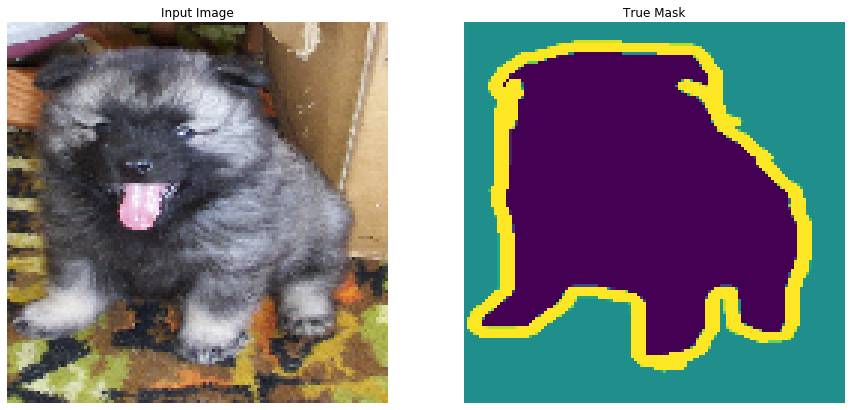

In [64]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [18]:
IMG_SHAPE = (128, 128, 3)
NUM_CLASSES = 3
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [20]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [22]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [23]:
from IPython.display import clear_output

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
model = UNet().create_model(IMG_SHAPE, NUM_CLASSES)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_dataset, epochs=5,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])